In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
import counterstone as cs

IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
toxdata = pd.read_csv('BBBP.csv')
toxdata = toxdata
toxdata.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [2]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
try:
    raw_features = pd.read_pickle('raw_features.pb')
except FileNotFoundError as e:
    raw_features = calc.pandas(valid_mols, nproc=8)
    raw_features.to_pickle('raw_features.pb')

In [3]:
labels = toxdata[valid_mol_idx].p_np

In [4]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

AUC 0.914832285115304


<Figure size 1200x900 with 0 Axes>

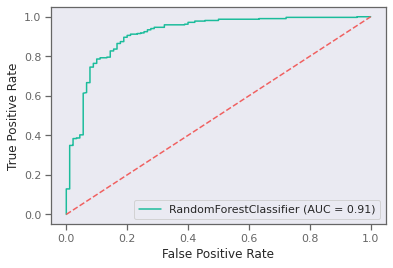

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True)

clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
plt.figure(figsize=(4,3), dpi=300)
plot_roc_curve(clf, X_test, y_test)
plt.plot([0,1],[0,1], linestyle='--')
plt.savefig('RF-ROC.png')

In [6]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    raw_features = calc.pandas(molecules, nproc=8, quiet=True)
    features = feature_convert(raw_features)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
    #return np.random.choice([True, False], size=labels.shape)
labels = model_eval(toxdata.iloc[valid_mol_idx].smiles.values[:100])

In [7]:
example_neg = toxdata.iloc[valid_mol_idx].smiles.values[np.argmin(labels)]
example_pos = toxdata.iloc[valid_mol_idx].smiles.values[np.argmax(labels)]
example_neg_y, example_pos_y = model_eval([example_neg, example_pos])
print('neg:', example_neg, '\npos:', example_pos)
print(example_neg_y, example_pos_y)

neg: Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O 
pos: [Cl].CC(C)NCC(O)COc1cccc2ccccc12
0 1


In [8]:
space = cs.sample_space(example_neg, model_eval)

STONED Round Complete with 1500
STONED Round Complete with 1500


In [9]:
exps = cs.counterfactual_explain(space)
print(exps)

[Examples(smiles='Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O', selfies=None, similarity=1.0, yhat=0, index=0, position=array([-10.51971722,   2.01122711]), is_origin=True, cluster=-1, label=None), Examples(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2I', selfies='', similarity=0.8, yhat=1, index=1649, position=array([-8.02051186, -0.24561473]), is_origin=False, cluster=-1, label='Counterfactual'), Examples(smiles='CCOC1N2C(=O)C(NC(=O)c3c(-c4ccccc4Cl)noc3C)C2SC1(C)C', selfies='', similarity=0.7472527472527473, yhat=1, index=244, position=array([-7.36386186, -0.24397353]), is_origin=False, cluster=4, label='Counterfactual'), Examples(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2PC#[S+]', selfies='S+', similarity=0.7472527472527473, yhat=1, index=1782, position=array([-6.93904534, -0.26577388]), is_origin=False, cluster=62, label='Counterfactual')]


In [10]:
def counterfactual_explain(examples, nmols=3):
    result = []

    def is_counter(e):
        return e.yhat != examples[0].yhat

    # similarit filtered by if cluster/counter
    def cluster_score(e, i):
        return (e.cluster == i) * is_counter(e) * e.similarity
    clusters = set([e.cluster for e in examples])
    for i in clusters:
        close_counter = max(examples, key=lambda e,
                            i=i: cluster_score(e, i))
        # check if actually is (since call could have been off)
        if cluster_score(close_counter, i):
            result.append(close_counter)

    # trim, in case we had too many cluster
    result = sorted(result, key=lambda v: v.similarity * is_counter(v), reverse=True)[:nmols]

    # fill in remaining
    ncount = sum([is_counter(e) for e in result])
    fill = max(0, nmols - ncount)
    result.extend(sorted(examples, key=lambda v: v.similarity * is_counter(v),
                         reverse=True)[:fill])

    return examples[:1] + result
exps = counterfactual_explain(space)

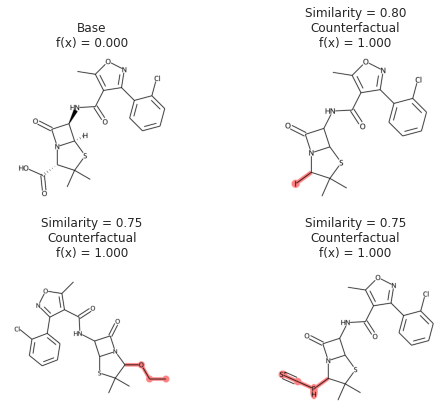

In [14]:
fkw = {'figsize': (8,6)}
cs.plot_explanation(exps, figure_kwargs=fkw, mol_size=(450,400))
plt.savefig('rf-simple.png', dpi=90)

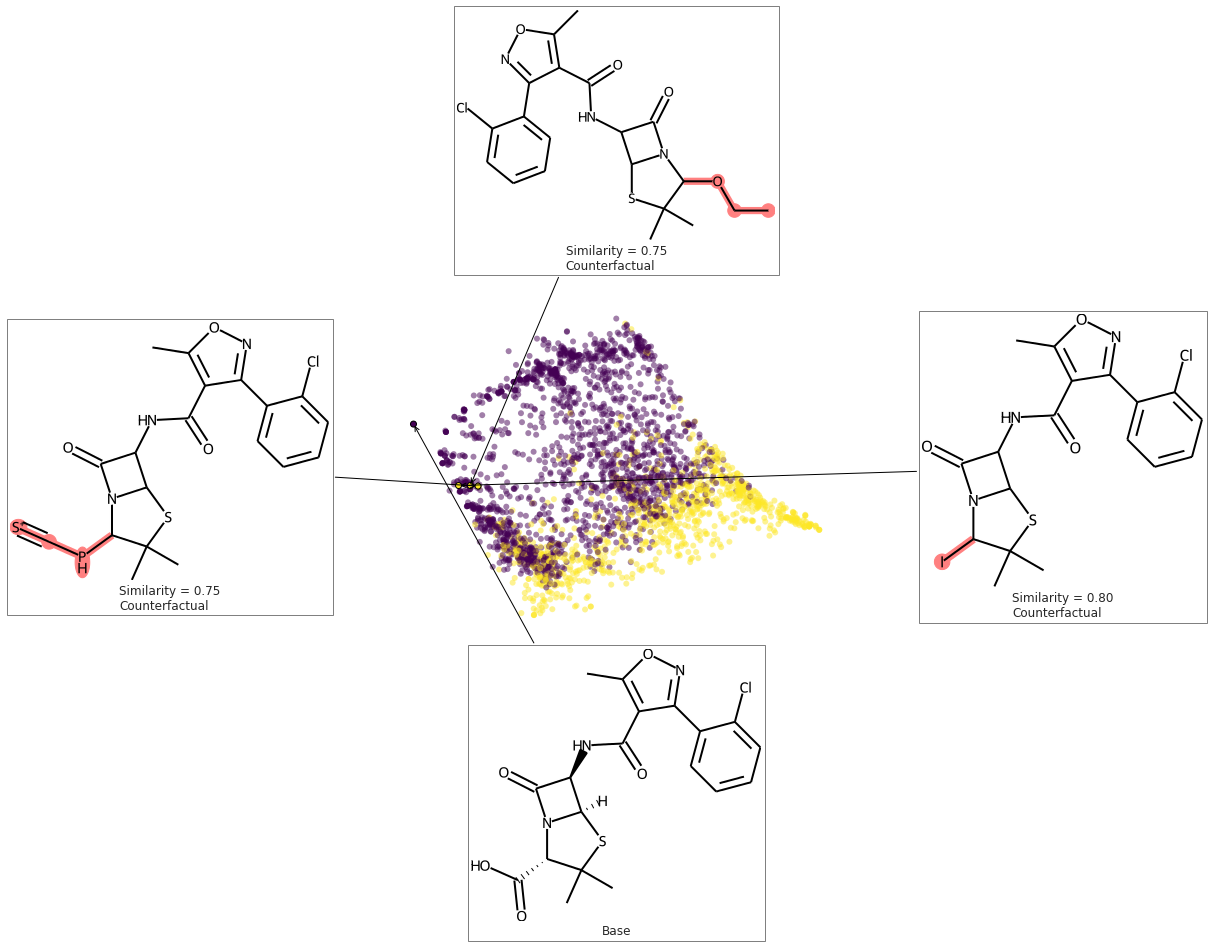

In [12]:
fkw = {'figsize': (8,6)}
cs.plot_space(space, exps, figure_kwargs=fkw, mol_size=(350,300))
plt.savefig('rf-space.png', bbox_inches='tight', dpi=90)